In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [ ]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Funciones

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

def tune_params(train_X, train_Y, test_X, test_Y):

    b_par={} #A void dictionary which will contain the best params in each iteration

    #TUNING TREES
    #INTIAL MODEL
    model=xgb.XGBClassifier(objective='binary:logistic',
                        learning_rate=0.2,
                        max_depth=7,
                        min_child_weight=5,
                        reg_lambda=1010,
                        n_estimators=150)

    #NUMBER OF TREES
    eval_set = [(train_X, train_Y), (test_X, test_Y)]
    eval_metric = ["auc","error"]
    %time model.fit(train_X, train_Y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

    # Evaluation results
    evaluation_results = model.evals_result_
    auc_train = evaluation_results["validation_0"]["auc"] # Train ‘auc’ metric
    auc_test = evaluation_results["validation_1"]["auc"] # Test ‘auc’ metric


    # Plotting ‘XGBOOST Classification Error’ and ‘XGBOOST Classification AUC’
    plt.figure(figsize=(7,7))
    plt.plot(auc_train)
    plt.plot(auc_test)
    plt.xlabel('Number of trees (n_estimators)')
    plt.ylabel('auc')
    plt.legend(['Train', 'Test'])
    plt.title('XGBoost Classification AUC')
    plt.show()

    param_test1 = {
             'n_estimators':[100,150,200,250]
            }

    gsearch1 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

    gsearch1.fit(train_X,train_Y)

    b_par['n_estimators']=gsearch1.best_params_['n_estimators']

    #DEPTH AND WEIGHT TUNING
    v1=0

    param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

    gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              n_estimators=b_par['n_estimators'],
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

    gsearch2.fit(train_X,train_Y)
    v1+=1

    while gsearch2.best_score_ < gsearch1.best_score_ and v1!=2:

        param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

        gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              n_estimators=b_par['n_estimators'] ,
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

        gsearch2.fit(train_X,train_Y)
        v1+=1

    if gsearch2.best_score_ < gsearch1.best_score_:
        b_par['max_depth']=6
        b_par['min_child_weight']=1
        gsearch2.best_score_ = gsearch1.best_score_
        print(b_par)
    else:
        b_par['max_depth']= gsearch2.best_params_['max_depth']
        b_par['min_child_weight']= gsearch2.best_params_['min_child_weight']

    #GAMMA TUNING
    v2=0

    param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

    gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch3.fit(train_X,train_Y)
    v2+=1

    while gsearch3.best_score_ < gsearch2.best_score_ and v2!=2:
        param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

        gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch3.fit(train_X,train_Y)
        v2+=1

    if gsearch3.best_score_ < gsearch2.best_score_:
        b_par['gamma']=0
        gsearch3.best_score_ = gsearch2.best_score_
    else:
        b_par['gamma'] = gsearch3.best_params_['gamma']

    #SAMPLES TUNING
    v3=0

    param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


    gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch4.fit(train_X,train_Y)
    v3+=1

    while gsearch4.best_score_ < gsearch3.best_score_ and v3!=2:
        param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


        gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch4.fit(train_X,train_Y)
        v3+=1

    if gsearch4.best_score_ < gsearch3.best_score_:
        b_par['subsample']=1
        b_par['colsample_bytree']=1
        gsearch4.best_score=gsearch3.best_score_
    else:
        b_par['subsample'] = gsearch4.best_params_['subsample']
        b_par['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']

    #REGULARIZATION TUNING
    v4=0

    param_test6 = {
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[200, 300, 400, 500, 600]
        }

    gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch5.fit(train_x,train_y)
    v4+=1

    while gsearch5.best_score_ < gsearch4.best_score_ and v4!=2:
        param_test6 = {
         'reg_alpha' :[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[200, 300, 400, 500, 600]
        }

        gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch5.fit(train_x,train_y)

    if gsearch5.best_score_ < gsearch4.best_score_:
        b_par['reg_alpha']=0
        b_par['reg_lambda']=1
        gsearch5.best_score_=gsearch4.best_score_
    else:
        b_par['reg_alpha'] = gsearch5.best_params_['reg_alpha']
        b_par['reg_lambda']= gsearch5.best_params_['reg_lambda']

    #STUFF
    model = xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.2,
                                n_estimators=b_par['n_estimators'],
                                reg_lambda=b_par['reg_lambda'],
                                reg_alpha=b_par['reg_alpha'],
                                max_depth=b_par['max_depth'],
                                min_child_weight=b_par['min_child_weight'],
                                gamma=b_par['gamma'],
                                subsample=b_par['subsample'],
                                colsample_bytree=b_par['colsample_bytree'])
    model.fit(train_X, train_Y)

    #ROC CURVE
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=13)
    model_predict = model.predict_proba(test_X)
    model_predict = model_predict[:,1]
    auc_score_test = roc_auc_score(test_Y, model_predict)
    fpr, tpr, _ = roc_curve(test_Y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score_test)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score_test, 4)), color='purple')

    model_predict = model.predict_proba(train_X)
    model_predict = model_predict[:,1]
    auc_score_train = roc_auc_score(train_Y, model_predict)
    fpr, tpr, _ = roc_curve(train_Y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score_train, 4)) , color='orange', linewidth=3)
    print('Train : ', auc_score_train)
    plt.legend(fontsize=13)
    plt.ylabel('background rejection', fontsize=13)
    plt.xlabel('Signal efficiency', fontsize=13)
    plt.show()

    return b_par

# Sección nueva

In [ ]:
def roc(test_x,test_y,train_x,train_y):
    """"
    Presenta la curva roc, que muestra la precisión del clasificador, entre mas
    cercana sea el area 1 mejor será el clasificador """
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=20)
    model_predict = model.predict_proba(test_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(test_y, model_predict)
    fpr, tpr, _ = roc_curve(test_y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score, 4)), color='purple', linewidth=3)

    model_predict = model.predict_proba(train_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(train_y, model_predict)
    fpr, tpr, _ = roc_curve(train_y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score,4)) , color='orange', linewidth=3)
    print('Train : ', auc_score)
    plt.legend(loc='best',fontsize=20)
    plt.ylabel('Background Rejection', fontsize=20)
    plt.xlabel('Signal efficiency', fontsize=20)
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.ylim(0.7,1)
    plt.show()

In [ ]:
RD = pd.read_pickle('Signal_5.pkl')
MC = pd.read_pickle('Right_5.pkl')

MC.head()

,run,event,luminosityBlock,Bpt,kpt,PDL,prob,cosA,signLxy,BMass,cosThetaKMu,DiMuMass
846557,316569,2419032308,1750,3.197039,0.754576,0.027220,0.015701,0.980964,3.319806,5.549367,0.387938,0.652236
602916,319349,121163061,86,5.740430,4.778899,0.014964,0.166422,0.667695,4.977643,5.540707,0.541980,2.200779
693903,320006,24668633,17,21.223192,1.811541,0.005489,0.018952,0.951301,3.242698,5.663490,0.658956,4.765600
1397520,317650,1509589239,1008,19.846544,0.576531,0.009391,0.256810,0.999062,1.835706,5.684946,-0.019215,1.011200
500805,317320,2433775391,1620,10.660144,1.885670,0.007417,0.386343,0.984047,1.486022,5.409599,0.946179,2.098343


In [ ]:
RD = RD[['Bpt', 'PDL', 'prob', 'kpt', 'signLxy', 'cosA']]
MC = MC[['Bpt', 'PDL', 'prob', 'kpt', 'signLxy', 'cosA']]

In [ ]:
RD_train, RD_test = train_test_split(RD)

MC_train, MC_test = train_test_split(MC)

In [ ]:
train_x = RD_train.append(MC_train)
test_x  = RD_test.append(MC_test)

In [ ]:
train_y = np.append(np.ones(len(RD_train), dtype=float), np.zeros(len(MC_train), dtype=float)) #labels
test_y  = np.append(np.ones(len(RD_test), dtype=float), np.zeros(len(MC_test), dtype=float))

[0]	validation_0-auc:0.927146	validation_0-error:0.042667	validation_1-auc:0.918974	validation_1-error:0.0484
[1]	validation_0-auc:0.930881	validation_0-error:0.042933	validation_1-auc:0.921927	validation_1-error:0.0492
[2]	validation_0-auc:0.935453	validation_0-error:0.047333	validation_1-auc:0.925941	validation_1-error:0.0532
[3]	validation_0-auc:0.948111	validation_0-error:0.0444	validation_1-auc:0.939114	validation_1-error:0.0484
[4]	validation_0-auc:0.948365	validation_0-error:0.043867	validation_1-auc:0.939381	validation_1-error:0.048
[5]	validation_0-auc:0.94843	validation_0-error:0.0436	validation_1-auc:0.939404	validation_1-error:0.048
[6]	validation_0-auc:0.948504	validation_0-error:0.043067	validation_1-auc:0.939465	validation_1-error:0.048
[7]	validation_0-auc:0.95943	validation_0-error:0.0436	validation_1-auc:0.950727	validation_1-error:0.0488
[8]	validation_0-auc:0.967253	validation_0-error:0.043467	validation_1-auc:0.959836	validation_1-error:0.048
[9]	validation_0-auc:0

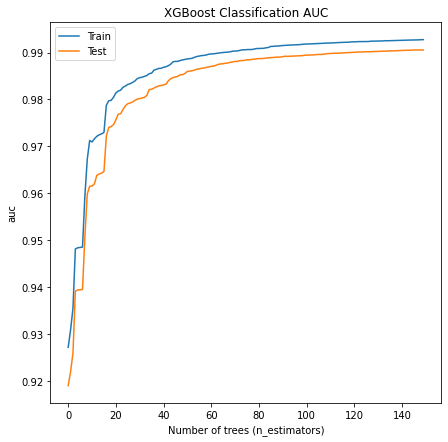

{'n_estimators': 250, 'max_depth': 6, 'min_child_weight': 1}
Test :  0.994757
Train :  0.9974090000000001


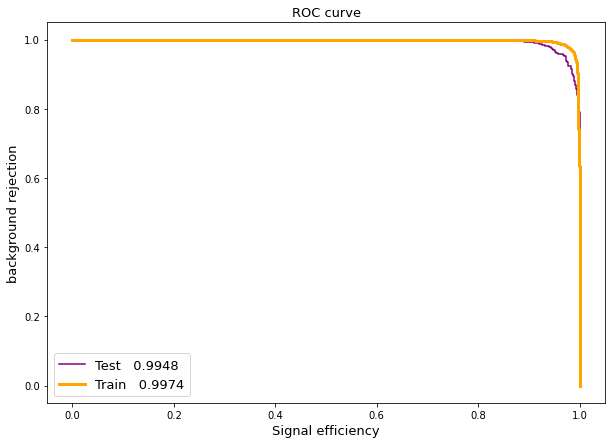

In [ ]:
par = tune_params(train_x, train_y, test_x, test_y)

In [ ]:
par

{'colsample_bytree': 1,
 'gamma': 0.15,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 250,
 'reg_alpha': 1,
 'reg_lambda': 200,
 'subsample': 1}

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          learning_rate=0.2,
                          gamma=0.15,
                          min_child_weight=1,
                          n_estimators=250,
                          reg_alpha=1,
                          reg_lambda=200,
                          colsample_bytree=1,
                          subsample=1,
                          max_depth=6)

In [ ]:
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.15,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=200, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Test :  0.994757
Train :  0.9974090000000001


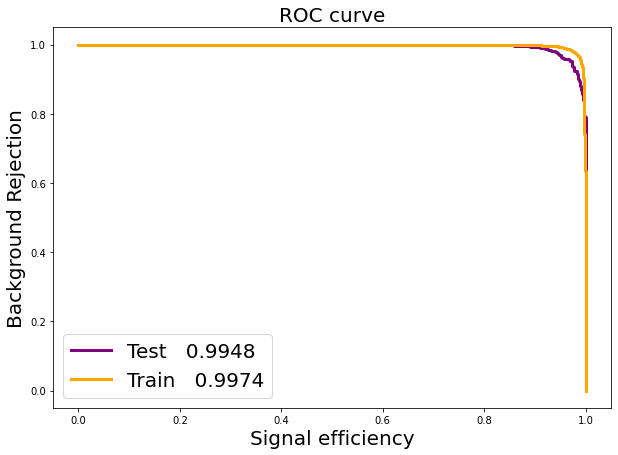

In [ ]:
roc(test_x, test_y, train_x, train_y)

In [ ]:
if 'XGB' not in MC:
    MC['XGB'] = model.predict_proba(MC)[:,1] #probability of being real data
if 'XGB' not in RD:
    RD['XGB'] = model.predict_proba(RD)[:,1] #probability of being RD

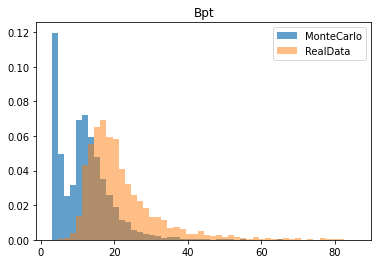

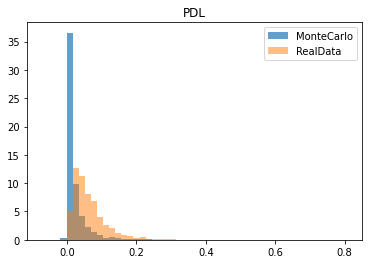

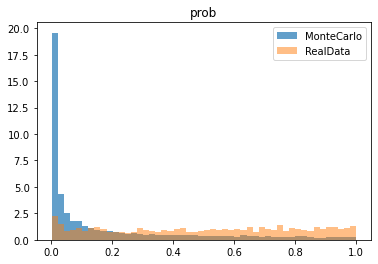

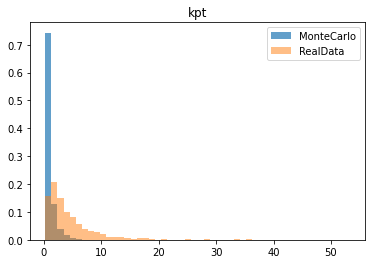

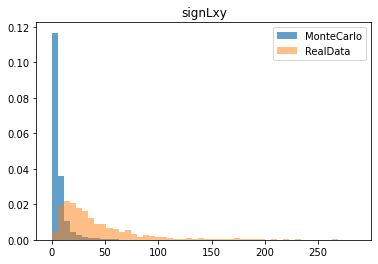

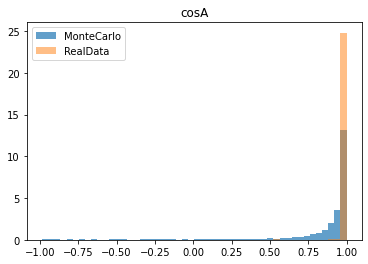

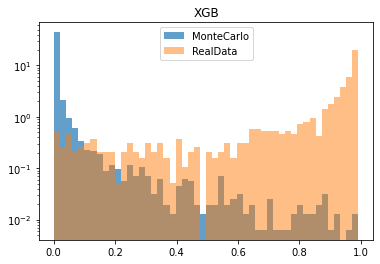

In [ ]:
for k in MC:
    plt.title(k)
    h = plt.hist(MC[k], bins=50, label='MonteCarlo', alpha = 0.7, color='tab:blue', density=True)
    plt.hist(RD[k], bins=h[1], label='RealData', alpha = 0.5, color='tab:orange', density=True)
    plt.legend(frameon=True)
    if k == 'XGB': plt.yscale('log')
    plt.show()

In [ ]:
weights = MC['XGB']/(1-MC['XGB'])

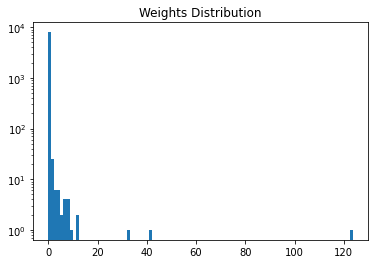

In [ ]:
plt.title('Weights Distribution')
plt.hist(weights, bins=100)
plt.yscale('log')
plt.show()

In [ ]:
np.any(MC['XGB']==1)

False

In [ ]:
!pip install hep_ml

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 2.8MB 8.9MB/s 
  Created wheel for theano: filename=Theano-1.0.5-cp37-none-any.whl size=2668111 sha256=75c9a31de92670e7ccb60301bf920b0dc1c5408544f510ca959849a01831e7c1
  Stored in directory: /root/.cache/pip/wheels/89/40/74/3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c
Successfully built theano


In [ ]:
from scipy import stats
#import hep_ml
from hep_ml.metrics_utils import ks_2samp_weighted

import ks_test

In [ ]:
MC

,Bpt,PDL,prob,kpt,signLxy,cosA,XGB
846557,3.197039,0.027220,0.015701,0.754576,3.319806,0.980964,0.001002
602916,5.740430,0.014964,0.166422,4.778899,4.977643,0.667695,0.002903
693903,21.223192,0.005489,0.018952,1.811541,3.242698,0.951301,0.014115
1397520,19.846544,0.009391,0.256810,0.576531,1.835706,0.999062,0.017273
500805,10.660144,0.007417,0.386343,1.885670,1.486022,0.984047,0.004370
...,...,...,...,...,...,...,...
672911,17.424704,0.000716,0.184582,2.186565,3.088632,0.526190,0.006597
297742,5.479703,0.010051,0.001046,1.318756,3.716656,0.925099,0.001033
1103006,13.090983,0.007505,0.262427,2.619250,2.464988,0.851963,0.005389
2130648,12.989970,0.016402,0.190406,0.571891,3.263517,0.968041,0.001952


In [ ]:
for j in MC:
  print(j)

Bpt
PDL
prob
kpt
signLxy
cosA
XGB


In [ ]:
RD['Bpt']

15527    53.841000
28009    13.345943
19944    19.678831
26067    14.061918
36365    20.260057
           ...    
5426     14.846232
12000    15.361895
37194    32.588638
24042    20.832119
51079    18.810871
Name: Bpt, Length: 2000, dtype: float32

In [ ]:
print('K-S Test Final: ', ks_test.ks_2samp_weighted(RD[Bpt], MC[Bpt], weights2=weights))

NameError: ignored

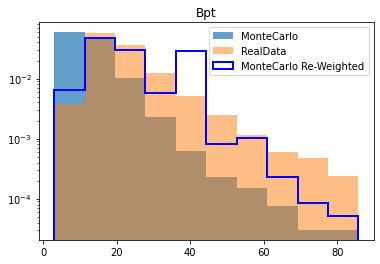

K-S Test 1:  0.5238125000000166
K-S Test:  0.19969448203897988


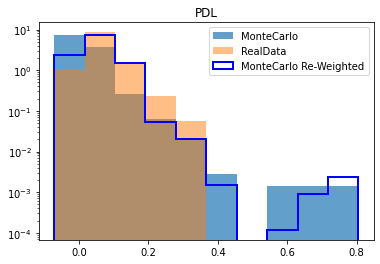

K-S Test 1:  0.5751875000000355
K-S Test:  0.1454204719979425


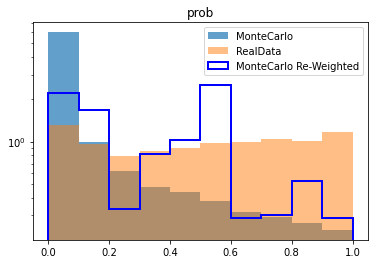

K-S Test 1:  0.47756250000000855
K-S Test:  0.3513517427387702


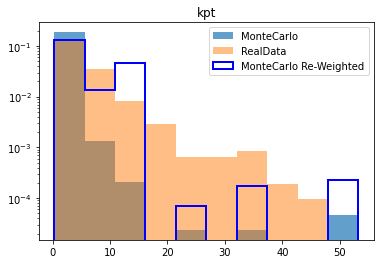

K-S Test 1:  0.624562500000057
K-S Test:  0.2703781585058658


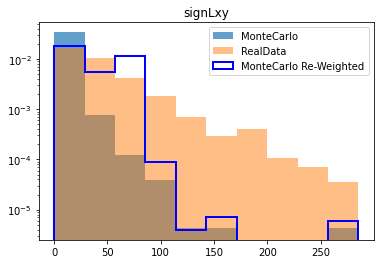

K-S Test 1:  0.7371875000000822
K-S Test:  0.1739045111749964


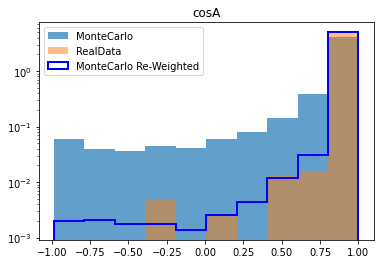

K-S Test 1:  0.7966875000000885
K-S Test:  0.3430260401481069


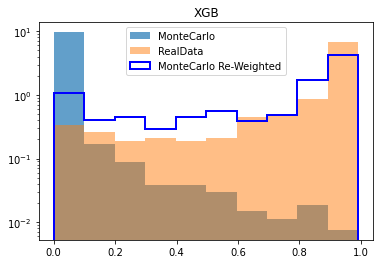

K-S Test 1:  0.9478125000001171
K-S Test:  0.5137499447466048


In [ ]:
bins = 10
for k in MC:
    plt.title(k)
    h = plt.hist(MC[k], bins=bins, label='MonteCarlo', alpha = 0.7, color='tab:blue', density=True)
    train = plt.hist(RD[k], bins=h[1], label='RealData', alpha = 0.5, color='tab:orange', density=True)
    plt.hist(MC[k], bins=h[1], label='MonteCarlo Re-Weighted', histtype='step',  color='blue',
             linewidth = 2, weights=weights, density=True)

    #train = plt.histogram(MC[k], bins=h[1]. alpha=0.5,)#, density=True)
    #bins_ = (train[1][1:]+train[1][:-1])/2
    #plt.errorbar(bins_, train[0],yerr=np.sqrt(train[0]),
    #             fmt='s', marker='o' ,color='darkgreen',
    #            barsabove=False, capsize=5, label='Train Signal')

    plt.legend(frameon=True)

    if k == 'XGB' or 'Bpt' or 'kpt' or 'PDL' or 'prob' or 'cosA' or 'signLxy':
        plt.yscale('log')
    plt.show()

    #print(ks_test.ks_2samp_weighted(RD[k], MC[k], weights2=weightsRD))

    print('K-S Test 1: ', ks_2samp_weighted(MC[k], RD[k], weights1=np.ones(len(MC), dtype=float), weights2=np.ones(len(RD), dtype=float)))
    print('K-S Test: ', ks_2samp_weighted(MC[k], RD[k], weights1=weights, weights2=np.ones(len(RD), dtype=float)))

In [ ]:
import pickle
pickle.dump(model, open('modelo_L5.pkl', 'wb'))

In [ ]:
]